In [54]:
import numpy as np
import scipy.optimize
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [55]:
# load in the data
data = pd.read_csv("../../data/competition_experiments/20200218_wt_v_delta.csv")

In [56]:
# remove spurious data point
data_trimmed = data[data["time (hr)"] != 19]
data_trimmed

,time (hr),time (min),time since start (min),number of wildtype colonies,number of delta colonies,dilution factor,µL plated,wildtype / mL,delta / mL
0,11,10,0,178,101,10,100,17800,10100
1,12,20,70,116,83,10,100,11600,8300
2,13,10,120,142,99,10,100,14200,9900
3,14,10,180,159,85,10,100,15900,8500
4,15,10,240,22,9,100,100,22000,9000
5,17,0,350,37,9,100,100,37000,9000
6,18,0,410,185,47,100,100,185000,47000
8,20,45,575,52,18,1000,100,520000,180000
9,22,45,695,224,43,1000,100,2240000,430000


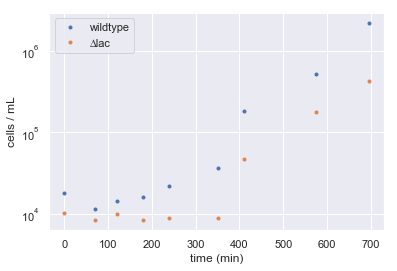

In [57]:
# plot
times = data_trimmed["time since start (min)"]
N_wildtype = data_trimmed["wildtype / mL"]
N_delta = data_trimmed["delta / mL"]

plt.semilogy(times, N_wildtype, '.')
plt.semilogy(times, N_delta, '.')
plt.xlabel("time (min)")
plt.ylabel("cells / mL")
plt.legend(["wildtype", "∆lac"])

In [58]:
def exp_growth(times, N_0, r, t_thresh):
    """ exponential growth with time points t, initial population size N_0, 
    and growth rate r """
    
    N = np.zeros(len(times))
    
    for i, t in enumerate(times):
        if t < t_thresh:
            N[i] = N_0
            
        else:
            N[i] = N_0 * np.exp((t-t_thresh)*r)
            
    return N

In [59]:
exp_growth(times, 1000, 0.005, 200)

array([ 1000.        ,  1000.        ,  1000.        ,  1000.        ,
        1221.40275816,  2117.00001661,  2857.65111806,  6520.81912033,
       11881.7071131 ])

In [60]:
# optimize growth curve
# bounds on N_O: 1000 to 100,000
# bound on r: 0.001 to 0.1 (per min)
popt_wt, pcov_wt = scipy.optimize.curve_fit(exp_growth, times, N_wildtype, 
                                      bounds=([1000, 0.001, 0], [100000, 0.1, 700]))

popt_delta, pcov_delta = scipy.optimize.curve_fit(exp_growth, times, N_delta, 
                                      bounds=([1000, 0.001, 0], [100000, 0.1, 700]))

Text(0, 0.5, 'cells / mL')

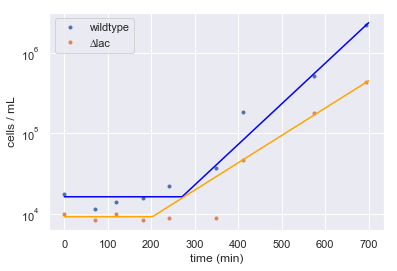

In [65]:
# plot data 
plt.semilogy(times, N_wildtype, '.')
plt.semilogy(times, N_delta, '.')
plt.legend(["wildtype", "∆lac"])

time_range = np.linspace(0, 700, 200)

# plot fits
plt.semilogy(time_range, exp_growth(time_range, *popt_wt), color="blue")
plt.semilogy(time_range, exp_growth(time_range, *popt_delta), color="orange")
plt.xlabel("time (min)")
plt.ylabel("cells / mL")